## Integrate model inter-cluster with three clustering

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import copy

import os
import sys
import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import random

from collections import defaultdict

from torch_geometric.nn import GCNConv

from utils import *
from Custom_GCNConv import Net
from Cluster_Machine import ClusteringMachine
from Cluster_Trainer import ClusterGCNTrainer_mini_Train, wholeClusterGCNTrainer_sequence

# import data
from torch_geometric.datasets import CoraFull

### Use Trivial data

In [3]:
'''Trivial data'''
edge_index = torch.tensor([[0, 1, 1, 3, 1, 2, 4, 2, 4, 6, 6, 7, 7, 9, 2, 5, 9, 8], 
                           [1, 0, 3, 1, 2, 1, 2, 4, 6, 4, 7, 6, 9, 7, 5, 2, 8, 9]])
# features = torch.rand(10, 3)
features = torch.tensor([[0, 0], [0, 1], [0, 2], [0, 3], [0, 4],  
                           [0, 5], [0, 6], [0, 7], [0, 8], [0, 9]], dtype = torch.float)
# label = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

label = torch.tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 0])
print(features, features.shape)

check_clustering_machine = ClusteringMachine(edge_index, features, label)

tensor([[0., 0.],
        [0., 1.],
        [0., 2.],
        [0., 3.],
        [0., 4.],
        [0., 5.],
        [0., 6.],
        [0., 7.],
        [0., 8.],
        [0., 9.]]) torch.Size([10, 2])


#### mini batch train nodes and valid throughout whole graph

<font color=orange>
Note: the all_overlap and train_overlap are the same effects in the train process
    
These two differ in the validation part. Train_overlap will lose some overalpping in the validation nodes which affect F1 score

In [4]:
# mini-batch of the all_overlap
clustering_machine = copy.deepcopy(check_clustering_machine)
clustering_machine.split_whole_nodes_edges_then_cluster(0.4, 0.4, valid_part_num = 2, train_part_num = 2, test_part_num = 2)
clustering_machine.mini_batch_train_clustering(1) # include number of layers
# check_clustering(clustering_machine)


In [5]:
gcn_trainer_batch = ClusterGCNTrainer_mini_Train(clustering_machine, 2, 2, input_layers = [16], dropout=0.3)
gcn_trainer_batch.train(1, 0.0001, 0.1)
gcn_trainer_batch.validate()


(0.25, 0.25)

### minibatch train nodes and batch validatioin 

In [6]:
clustering_machine = copy.deepcopy(check_clustering_machine)
clustering_machine.split_whole_nodes_edges_then_cluster(0.4, 0.4, valid_part_num = 2, train_part_num = 2, test_part_num = 2)
clustering_machine.mini_batch_train_clustering(1) # include number of layers
gcn_trainer_batch = ClusterGCNTrainer_mini_Train(clustering_machine, 2, 2, input_layers = [16], dropout=0.3)
gcn_trainer_batch.train(1, 0.0001, 0.1)
gcn_trainer_batch.batch_validate()

(0.5, 0.5)

#### Default whole graph (recombine train nodes)

In [7]:
# default brute force case: recombination whole graph
clustering_machine = copy.deepcopy(check_clustering_machine)
clustering_machine.split_whole_nodes_edges_then_cluster(0.4, 0.4, valid_part_num = 2, train_part_num = 2, test_part_num = 2)
clustering_machine.mini_batch_train_clustering(0)      
gcn_trainer_whole = wholeClusterGCNTrainer_sequence(clustering_machine, 2, 2, input_layers = [16], dropout=0.3)
gcn_trainer_whole.train(1, 0.0001, 0.1)
gcn_trainer_whole.validate()

(0.5, 0.5)

#### mini-batch train nodes only in the isolated cluster

In [8]:
# mini-batch of the isolate
clustering_machine = copy.deepcopy(check_clustering_machine)
clustering_machine.split_cluster_nodes_edges(0.2, 0.4, partition_num = 2)
clustering_machine.general_isolate_clustering(2) 


In [9]:
gcn_trainer_isolate = ClusterGCNTrainer_mini_Train(clustering_machine, 2, 2, input_layers = [16])
gcn_trainer_isolate.train(1,  0.0001, 0.1)
gcn_trainer_isolate.validate()

(0.5, 0.5)

### Use library data to check the results


### Utility Functions to be used and adjusted

In [10]:
def set_clustering_machine(data, test_ratio = 0.05, validation_ratio = 0.85, valid_part_num = 8, train_part_num = 8, test_part_num = 8):
    connect_edge_index, connect_features, connect_label = filter_out_isolate(data.edge_index, data.x, data.y)
    clustering_machine = ClusteringMachine(connect_edge_index, connect_features, connect_label)
#     clustering_machine.split_cluster_nodes_edges(test_ratio, validation_ratio, partition_num = train_part_num)
    # mini-batch only: split to train test valid before clustering
    clustering_machine.split_whole_nodes_edges_then_cluster(test_ratio, validation_ratio, valid_part_num = valid_part_num, train_part_num = train_part_num, test_part_num = test_part_num)
    return clustering_machine

def execute_one(clustering_machine, image_path, repeate_time = 5, input_layer = [32, 16], epoch_num = 300, layer_num = 1, \
                dropout = 0.3, lr = 0.0001, weight_decay = 0.01, mini_epoch_num = 5):
    """
        return all test-F1 and validation-F1 for all four models
    """
#     test_f1 = {}
    validation_accuracy = {}
    validation_f1 = {}
    time_total_train = {}
    time_data_load = {}
    
    # Each graph model corresponds to one function below
#     graph_model = ['batch_valid', 'train_batch', 'whole_graph', 'isolate']
    
    # for the split into train-validation first case:  isolate won't work, since no sg_nodes_global is generated
    graph_model = ['batch_valid', 'train_batch', 'whole_graph']
    for i in range(repeate_time):
        model_res = []
        model_res.append(Cluster_train_valid_batch_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=epoch_num, neigh_layer = layer_num, \
                                                         dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num)[:4])
        
        model_res.append(Cluster_train_batch_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=epoch_num, neigh_layer = layer_num, \
                                                         dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num)[:4] )
        
        model_res.append(No_partition_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=epoch_num, 
                                                  dropout = dropout, lr = lr, weight_decay = weight_decay)[:4])
        
#         model_res.append(Isolate_clustering_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=epoch_num, neigh_layer = layer_num, \
#                                                         dropout = dropout, lr = lr, weight_decay = weight_decay)[:4])
        
        validation_accuracy[i], validation_f1[i], time_total_train[i], time_data_load[i] = zip(*model_res)
    return graph_model, validation_accuracy, validation_f1, time_total_train, time_data_load


"""To test one single model for different parameter values"""
def execute_tuning(tune_params, clustering_machine, image_path, repeate_time = 7, input_layer = [32, 32], epoch_num = 400, layer_num = 1, \
                  dropout = 0.1, lr = 0.0001, weight_decay = 0.1):
    """
        Tune all the hyperparameters
        1) learning rate
        2) dropout
        3) layer unit number
        4) weight decay
    """
    validation_accuracy = {}
    validation_f1 = {}
    time_total_train = {}
    time_data_load = {}
    
    res = [{tune_val : Cluster_train_valid_batch_run(clustering_machine, data_name, dataset, image_path, \
            input_layer = input_layer, epochs=epoch_num, neigh_layer = layer_num, \
            dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = tune_val)[:4] for tune_val in tune_params} for i in range(repeate_time)]
    
    for i, ref in enumerate(res):
        validation_accuracy[i] = {tune_val : res_lst[0] for tune_val, res_lst in ref.items()}
        validation_f1[i] = {tune_val : res_lst[1] for tune_val, res_lst in ref.items()}
        time_total_train[i] = {tune_val : res_lst[2] for tune_val, res_lst in ref.items()}
        time_data_load[i] = {tune_val : res_lst[3] for tune_val, res_lst in ref.items()}
        
    return validation_accuracy, validation_f1, time_total_train, time_data_load


def check_train_loss_converge(clustering_machine, data_name, dataset, image_path,  comments, input_layer = [32, 16], epoch_num = 300, layer_num = 1, dropout = 0.3, lr = 0.0001, weight_decay = 0.01, mini_epoch_num = 5):
    # mini-batch, but valid also in batches
    a3, v3, time3, load3, Cluster_train_valid_batch_trainer = Cluster_train_valid_batch_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=epoch_num, neigh_layer = layer_num, \
                                                                               dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num)
    draw_Cluster_train_valid_batch = draw_trainer_info(data_name, Cluster_train_valid_batch_trainer, image_path, 'train_valid_batch_' + comments)
    draw_Cluster_train_valid_batch.draw_ave_loss_per_node()
    
    # mini-batch, but valid with whole graph feature
    a0, v0, time0, load0, Cluster_train_batch_trainer = Cluster_train_batch_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=epoch_num, neigh_layer = layer_num, \
                                                                               dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num)
    draw_Cluster_train_batch = draw_trainer_info(data_name, Cluster_train_batch_trainer, image_path, 'train_batch_' + comments)
    draw_Cluster_train_batch.draw_ave_loss_per_node()
    
    # whole graph version, should not work for the large scale graph
    a2, v2, time2, load2, No_partition_trainer = No_partition_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=epoch_num, \
                                                                 dropout = dropout, lr = lr, weight_decay = weight_decay)
    draw_No_partition = draw_trainer_info(data_name, No_partition_trainer, image_path, 'whole_' + comments)
    draw_No_partition.draw_ave_loss_per_node()
    
#     # isolate clustering first before splitting to train, test, validation
    
#     a1, v1, time1, load1, Isolate_clustering_trainer = Isolate_clustering_run(clustering_machine, data_name, dataset, image_path, input_layer = input_layer, epochs=epoch_num, neigh_layer = layer_num, \
#                                                                              dropout = dropout, lr = lr, weight_decay = weight_decay)
#     draw_Isolate_clustering = draw_trainer_info(data_name, Isolate_clustering_trainer, image_path, 'Isolate_' + comments)
#     draw_Isolate_clustering.draw_ave_loss_per_node()

### Use data from pytorch geometric datasets

### Multi-run of the data

In [11]:
def output_train_loss(data, data_name, dataset, image_data_path, partition_nums, layers, dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 1):
    for partn in partition_nums:
        for GCN_layer in layers:
            net_layer = len(GCN_layer) + 1
            hop_layer = net_layer
            clustering_machine = set_clustering_machine(data, test_ratio = 0.05, validation_ratio = 0.85, valid_part_num = partn, train_part_num = partn, test_part_num = 8)
            print('Start checking train loss for partition num: ' + str(partn) + ' hop layer: ' + str(hop_layer))
            img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'
            check_train_loss_converge(clustering_machine, data_name, dataset, img_path, 'part_num_' + str(partn), input_layer = GCN_layer, epoch_num = 400, layer_num = hop_layer, \
                                     dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num)
            
#             # the cluster info cannot be drawn for spilt first case
#             clustering_machine.mini_batch_train_clustering(hop_layer)
#             draw_cluster_info(clustering_machine, data_name, img_path, comments = '_cluster_node_distr_' + str(hop_layer) + '_hops')
            
def output_F1_score(data, data_name, dataset, image_data_path, partition_nums, layers, dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20):            
    for partn in partition_nums:
        for GCN_layer in layers:
            net_layer = len(GCN_layer) + 1
            hop_layer = net_layer
            # here for the more custom way of train and validation, validatoin nodes and train nodes may have different number of batches
            clustering_machine = set_clustering_machine(data, test_ratio = 0.05, validation_ratio = 0.85, valid_part_num = partn, train_part_num = partn, test_part_num = 8)
            print('Start running for partition num: ' + str(partn) + ' hop layer ' + str(hop_layer))
            img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'

            graph_model, validation_accuracy, validation_f1, time_total_train, time_data_load = execute_one(clustering_machine, img_path, repeate_time = 7, input_layer = GCN_layer, epoch_num = 400, layer_num = hop_layer, \
                                                                dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num)

            validation_accuracy = store_data_multi_tests(validation_accuracy, data_name, graph_model, img_path, 'test_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(validation_accuracy, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'models', 'Accuracy')

            validation_f1 = store_data_multi_tests(validation_f1, data_name, graph_model, img_path, 'validation_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(validation_f1, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'models', 'F1 score')

            time_train = store_data_multi_tests(time_total_train, data_name, graph_model, img_path, 'train_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(time_train, data_name, 'train_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'models', 'Train Time (ms)')

            time_load = store_data_multi_tests(time_data_load, data_name, graph_model, img_path, 'load_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(time_load, data_name, 'load_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'models', 'Load Time (ms)')
            
def output_tune_param(data, data_name, dataset, image_data_path, partition_nums, layers, dropout = 0.1, lr = 0.0001, weight_decay = 0.1):
    for partn in partition_nums:
        for GCN_layer in layers:
            net_layer = len(GCN_layer) + 1
            hop_layer = net_layer
            clustering_machine = set_clustering_machine(data, test_ratio = 0.05, validation_ratio = 0.85, valid_part_num = partn, train_part_num = partn, test_part_num = 8)

            # Set the tune parameters and name
            tune_name = 'batch_epoch_num'
            tune_params = [400, 200, 100, 50, 20, 10, 5, 1]

            img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/' + 'tune_' + tune_name + '/'
            print('Start tuning for tuning param: ' + tune_name + ' partition num: ' + str(partn) + ' hop layer ' + str(hop_layer))


            validation_accuracy, validation_f1, time_total_train, time_data_load = execute_tuning(tune_params, clustering_machine, img_path, repeate_time = 7, \
                                                                                    input_layer = GCN_layer, epoch_num = 400, layer_num = hop_layer, \
                                                                                    dropout = dropout, lr = lr, weight_decay = weight_decay)

            validation_accuracy = store_data_multi_tuning(tune_params,validation_accuracy, data_name, img_path, 'accuracy_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(validation_accuracy, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'epochs_per_batch', 'Accuracy')

            validation_f1 = store_data_multi_tuning(tune_params, validation_f1, data_name, img_path, 'validation_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(validation_f1, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'epochs_per_batch', 'F1 score')

            time_train = store_data_multi_tuning(tune_params, time_total_train, data_name, img_path, 'train_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(time_train, data_name, 'train_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'epochs_per_batch', 'Train Time (ms)')

            time_load = store_data_multi_tuning(tune_params, time_data_load, data_name, img_path, 'load_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(time_load, data_name, 'load_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'epochs_per_batch', 'Load Time (ms)')

In [19]:
local_data_root = '/media/xiangli/storage1/projects/tmpdata/'
test_folder_name = 'hpc_simple_1/train_10%_full_neigh_random_split_tr_valid_first/'

### Cora dataset

In [20]:
from torch_geometric.datasets import Planetoid
data_name = 'Cora'
dataset = Planetoid(root = local_data_root + 'Planetoid/Cora', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name

partition_nums = [4, 8]
layers = [[], [32], [32, 32]]

# partition_nums = [2, 4, 8]
# layers = [[], [32], [32, 32], [32, 32, 32]]

#### Checking training loss

Start checking train loss for partition num: 8 hop layer: 1
Start checking train loss for partition num: 8 hop layer: 2


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

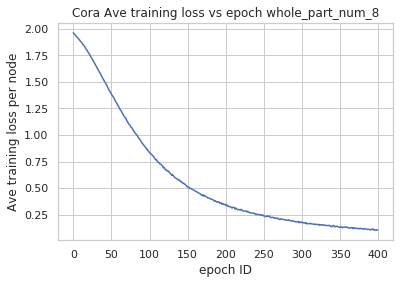

In [21]:
# check convergence
output_train_loss(data, data_name, dataset, image_data_path, partition_nums, layers, dropout = 0.1, lr = 0.0001, weight_decay = 0.1)

#### Output accuracy, F1, time (train, load)

Start running for partition num: 8 hop layer 1
Start running for partition num: 8 hop layer 2


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

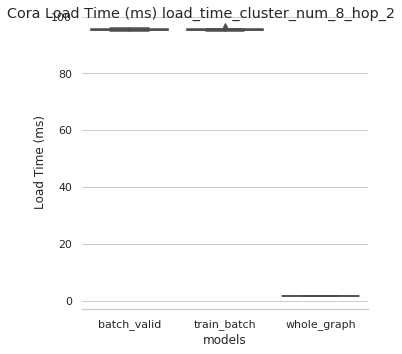

In [22]:
output_F1_score(data, data_name, dataset, image_data_path, partition_nums, layers, dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20)
        

#### tuning epoch number for each train-batch

Start tuning for tuning param: batch_epoch_num partition num: 8 hop layer 1
Start tuning for tuning param: batch_epoch_num partition num: 8 hop layer 2


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

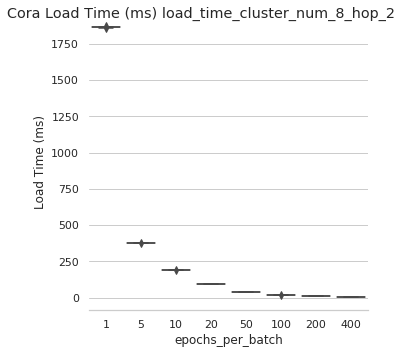

In [23]:
output_tune_param(data, data_name, dataset, image_data_path, partition_nums, layers, dropout = 0.1, lr = 0.0001, weight_decay = 0.1)


### CiteSeer Dataset

In [24]:
from torch_geometric.datasets import Planetoid
data_name = 'CiteSeer'
dataset = Planetoid(root = local_data_root + 'Planetoid/CiteSeer', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name

partition_nums = [4, 8]
layers = [[], [16], [16, 16]]

Start checking train loss for partition num: 4 hop layer: 1
Start checking train loss for partition num: 4 hop layer: 2
Start checking train loss for partition num: 4 hop layer: 3
Start checking train loss for partition num: 8 hop layer: 1
Start checking train loss for partition num: 8 hop layer: 2
Start checking train loss for partition num: 8 hop layer: 3


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

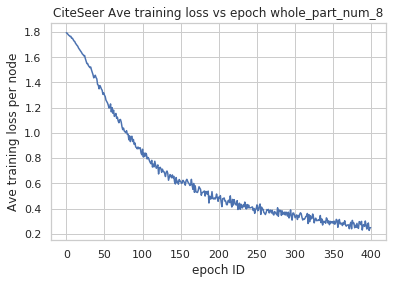

In [25]:
# check the train loss
output_train_loss(data, data_name, dataset, image_data_path, partition_nums, layers, dropout = 0.5, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 1)

Start running for partition num: 4 hop layer 1
Start running for partition num: 4 hop layer 2
Start running for partition num: 4 hop layer 3


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`ma

Start running for partition num: 8 hop layer 1


/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotl

Start running for partition num: 8 hop layer 2


/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotl

Start running for partition num: 8 hop layer 3


/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotl

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

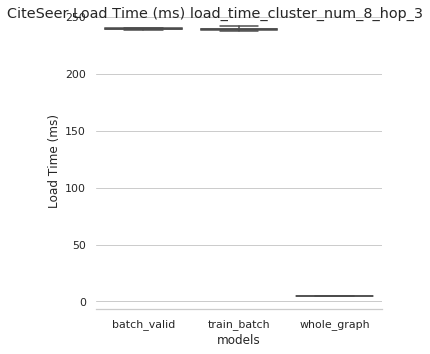

In [26]:
# output the F1 score
output_F1_score(data, data_name, dataset, image_data_path, partition_nums, layers, dropout = 0.5, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20)
        

### Tuning the epoch number per batch

Start tuning for tuning param: batch_epoch_num partition num: 4 hop layer 1
Start tuning for tuning param: batch_epoch_num partition num: 4 hop layer 2
Start tuning for tuning param: batch_epoch_num partition num: 4 hop layer 3


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`ma

Start tuning for tuning param: batch_epoch_num partition num: 8 hop layer 1


/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotl

Start tuning for tuning param: batch_epoch_num partition num: 8 hop layer 2


/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotl

Start tuning for tuning param: batch_epoch_num partition num: 8 hop layer 3


/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotl

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

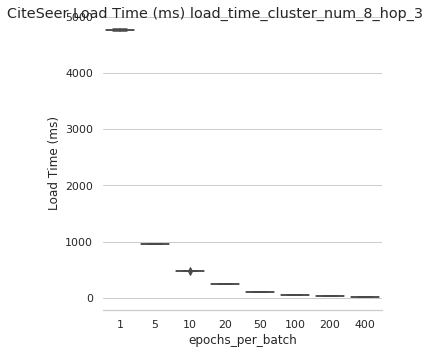

In [27]:
output_tune_param(data, data_name, dataset, image_data_path, partition_nums, layers, dropout = 0.5, lr = 0.0001, weight_decay = 0.1)

### PubMed dataset

In [28]:
from torch_geometric.datasets import Planetoid
data_name = 'PubMed'
dataset = Planetoid(root = local_data_root + 'Planetoid/PubMed', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name

partition_nums = [4, 8]
layers = [[], [64], [64, 64]]

Start checking train loss for partition num: 4 hop layer: 1
Start checking train loss for partition num: 4 hop layer: 2
Start checking train loss for partition num: 4 hop layer: 3
Start checking train loss for partition num: 8 hop layer: 1
Start checking train loss for partition num: 8 hop layer: 2
Start checking train loss for partition num: 8 hop layer: 3


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

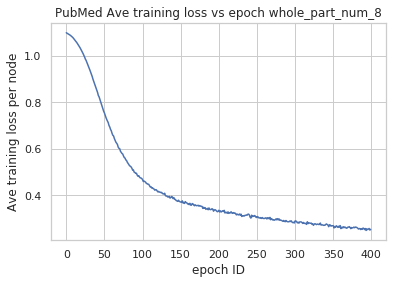

In [29]:
# check the train loss
output_train_loss(data, data_name, dataset, image_data_path, partition_nums, layers, dropout = 0.3, lr = 0.0001, weight_decay = 0.001, mini_epoch_num = 1)

Start running for partition num: 4 hop layer 1
Start running for partition num: 4 hop layer 2
Start running for partition num: 4 hop layer 3


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`ma

Start running for partition num: 8 hop layer 1


/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotl

Start running for partition num: 8 hop layer 2


/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotl

Start running for partition num: 8 hop layer 3


/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotl

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

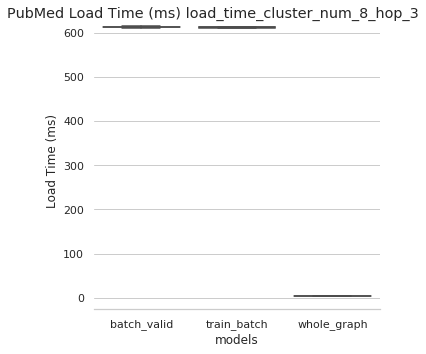

In [30]:
# output the F1 score
output_F1_score(data, data_name, dataset, image_data_path, partition_nums, layers, dropout = 0.3, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20)

Start tuning for tuning param: batch_epoch_num partition num: 4 hop layer 1
Start tuning for tuning param: batch_epoch_num partition num: 4 hop layer 2
Start tuning for tuning param: batch_epoch_num partition num: 4 hop layer 3


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`ma

Start tuning for tuning param: batch_epoch_num partition num: 8 hop layer 1


/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotl

Start tuning for tuning param: batch_epoch_num partition num: 8 hop layer 2


/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotl

Start tuning for tuning param: batch_epoch_num partition num: 8 hop layer 3


/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/media/xiangli/storage1/projects/large_scale_GCN/HPC_version/4_mini_batch_focus/utils.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotl

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

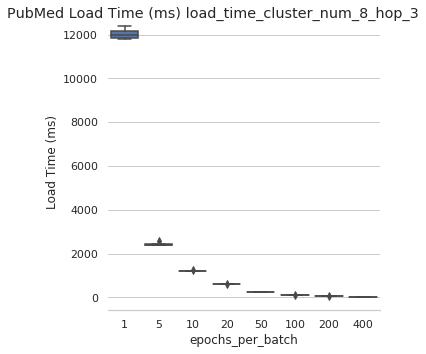

In [31]:
# tune the mini_epoch number after each time loading data to GPU
output_tune_param(data, data_name, dataset, image_data_path, partition_nums, layers, dropout = 0.3, lr = 0.0001, weight_decay = 0.1)

### Appendix

In [ ]:
# free GPU memory
# !(nvidia-smi | grep 'python' | awk '{ print $3 }' | xargs -n1 kill -9)